In [8]:
import nibabel as nib
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import nilearn.image
import sklearn.decomposition
from sklearn.linear_model import Ridge
#from fMRI_Regions import atlas
from fMRI_Regions import atlas_masker
import sklearn.metrics as sm
from sampler1 import Sampler
from settings import settings
from scipy import signal
import scipy
import time
import mne
import glob
sampler = Sampler('/Users/ilamiheev/Desktop/data/')
from scipy import signal
masker, labels = atlas_masker('sub')
path_new_set='/Users/ilamiheev/Downloads/coredf.set'
path_new='/Users/ilamiheev/Downloads/corrr.edf'
eeg = mne.io.read_raw_edf('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off/eeg_off_1.edf',exclude=['EOG', 'ECG','CW1', 'CW2','CW3','CW4','CW5','CW6','Status'])
#eeg = mne.io.read_raw_edf(path_new,exclude=['EOG', 'ECG','CW1', 'CW2','CW3','CW4','CW5','CW6','Status'])
data = eeg.get_data()
channels=eeg.ch_names
eeg1=data
f, t, ft = signal.stft(eeg1[:,0:2000],fs=1000, nperseg=400)
ix_chs = f[2:19] 
num_frames = 140
num_train_frames = 95
num_test_frames = 20
nmse_scores_off=[]
pearson_scores_off=[]
r2_scores_off=[]
#sampler_eeg=
Coefs=[]
index_dif=[]
eeg_set_off_paths=glob.glob("/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_off/*.set")
eeg_edf_off_paths=glob.glob("/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off/*.edf")
fmri_off_paths=glob.glob("/Users/ilamiheev/Downloads/eeg_fmri_data/fmri_off/*.nii")
forw_delay=0
patient_list=[1,2,3,4]
#find min number of volumes in all dataset and use it as end in interp1d
#plot the components of channels on topomap sculp
        #sto=patient_list[tau]
bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_off/eeg_set_1.set')
#bb=mne.io.read_raw_eeglab(path_new_set)
k=mne.events_from_annotations(bb)
eeg_path='/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off/eeg_off_1.edf'
#eeg_path=path_new
fmri_path='/Users/ilamiheev/Downloads/eeg_fmri_data/fmri_off/fmri_off_1.nii'
#fmri_path='/Users/ilamiheev/Downloads/eeg_fmri_data/CWL_Data/mri/epi_normalized/rwatrio1_eoec_in-scan_hpump-on.nii'
#another function for finding delay.
jj=k[1]['mri']
a,b=np.where(k[0]==jj)
delay=k[0][a[0],0]
fmri_end=k[0][a[-1],0]
print(delay)
print(fmri_end)
delayf=settings.frame_creation_time * 5 + delay
train_start = delayf
train_end = settings.frame_creation_time * (num_train_frames)+delay
test_start = settings.frame_creation_time * (num_frames - num_test_frames)+ delay
test_end = settings.frame_creation_time * (num_frames)+ delay
current_patient = 35
random_state = 42
x_train1, y_train, x_fl_train = sampler.create_one_man_dataset(patient=current_patient, start_time=train_start,
                                                          end_time=train_end, delay=delay,fmri_end=fmri_end,eeg_path=eeg_path,fmri_path=fmri_path, forw_delay=forw_delay)
x_test1, y_test, x_fl_test =  sampler.create_one_man_dataset(patient=current_patient, start_time=test_start,
                                                       end_time=test_end, delay=delay, fmri_end=fmri_end,eeg_path=eeg_path,fmri_path=fmri_path, forw_delay=forw_delay)
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scores= np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresr2 = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresmse = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
mm=[]
bbb=[]
x_train=x_train1*1e+4
x_test=x_test1*1e+4
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=False)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_train)[0],-1), y_train[:,zone]) 
            predicted_y_test = ridgereg.predict(x_test[:,a,:,:].reshape(np.shape(x_test)[0],-1))
            scores[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
            scoresr2[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_test)
            scoresmse[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_test)       
            t.append(ridgereg)
            nn.append(predicted_y_test)
        s.append(t)
        jj.append(nn)
    mm.append(s)
    bbb.append(jj)
mmm=np.array(mm)
bbb=np.array(bbb)
coefs=[]
scores_max1=[]
scores_max2=[]
scores_max3=[]
mmm=np.array(mmm)
R=[]
for zone in range(len(labels)-1):
    #sigm=[]
    #kkk=[]
    #for i in range(len(channels)):
    ind = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
    #ind=np.argmax(np.abs(scores[zone,i,...]))
    #kkk.append(mmm[zone,i,ind].coef_)
    coefs.append(mmm[zone,ind[0], ind[1]].coef_)
    #sigm.append(scores[zone,i,ind])
    scores_max1.append(scores[zone,ind[0],ind[1]])
    scores_max2.append(scoresmse[zone,ind[0],ind[1]])
    scores_max3.append(scoresr2[zone,ind[0],ind[1]])
    R.append(ind)
    #scores_max.append(sigm)
    #coefs.append(kkk)
coefs=np.array(coefs)
nmse_scores_off.append(scores_max2)
pearson_scores_off.append(scores_max1)
r2_scores_off.append(scores_max3)
Coefs.append(coefs)
index_dif.append(R)
#scores_max=np.array(scores_max)      

Extracting EDF parameters from /Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off/eeg_off_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-8-9253a1cd7e50>:47: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['EOG', 'ECG', 'CW1', 'CW2', 'CW3', 'CW4', 'CW5', 'CW6']. Their position has been left untouched.
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_off/eeg_set_1.set')
<ipython-input-8-9253a1cd7e50>:47: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_off/eeg_set_1.set')


Used Annotations descriptions: ['boundary', '[]', 'R', 'Sync On', 'mri', 'S201', 'beo', 'S  1', 'eeo', 'fl', 'S241', 'S  5', 'R255', 'R254', 'S221', 'bec', 'eec']
23322
300223
Extracting EDF parameters from /Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off/eeg_off_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-8-9253a1cd7e50>:47: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_off/eeg_set_1.set')


Setting up band-pass filter from 5 - 60 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 1651 samples (1.651 sec) selected


/Users/ilamiheev/.local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Extracting EDF parameters from /Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off/eeg_off_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 5 - 60 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 15.0 Hz
Filter length of 1651 samples (1.651 sec) selected


/Users/ilamiheev/.local/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [11]:
r2_scores_off

[[0.0690882927677523,
  0.08432498725876714,
  0.10379262070986028,
  0.3143364662488425,
  -0.07234149920129518,
  0.2151814806277781,
  0.6749234848837952,
  0.37758047935115446,
  0.056524955976210434,
  0.6105668571902823,
  0.4275413481253665,
  0.6229891207249167,
  -0.23488195072707452,
  0.0663557152119032,
  0.28349337295067434,
  0.414735229927531,
  0.4641433568600355,
  0.47759046381572456,
  0.17279220187684452,
  0.2002374073449803,
  0.36397605567952596]]

In [ ]:
R[0]

In [12]:
labels

['Background',
 'Left Cerebral White Matter',
 'Left Cerebral Cortex ',
 'Left Lateral Ventrical',
 'Left Thalamus',
 'Left Caudate',
 'Left Putamen',
 'Left Pallidum',
 'Brain-Stem',
 'Left Hippocampus',
 'Left Amygdala',
 'Left Accumbens',
 'Right Cerebral White Matter',
 'Right Cerebral Cortex ',
 'Right Lateral Ventricle',
 'Right Thalamus',
 'Right Caudate',
 'Right Putamen',
 'Right Pallidum',
 'Right Hippocampus',
 'Right Amygdala',
 'Right Accumbens']

<Montage | standard_1020 - 97 channels: LPA, RPA, Nz ...>


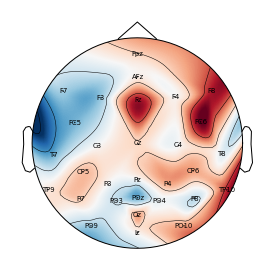

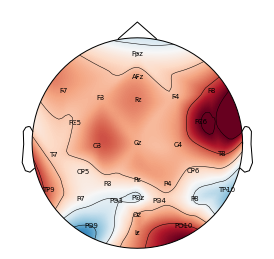

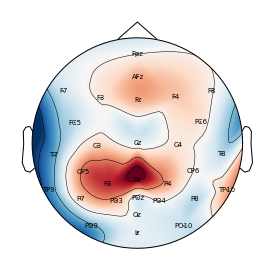

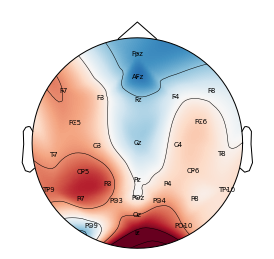

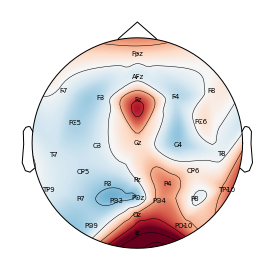

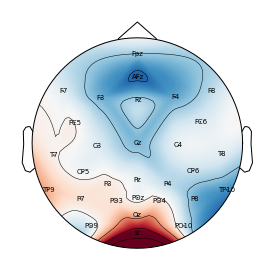

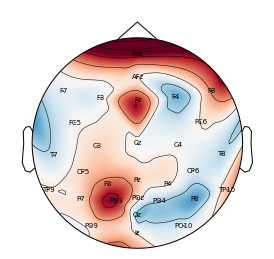

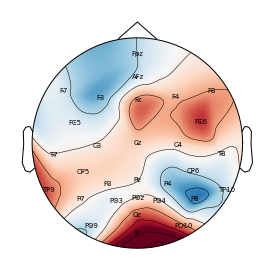

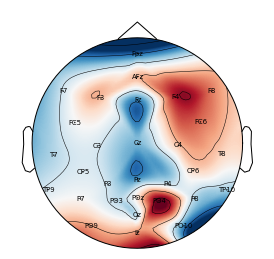

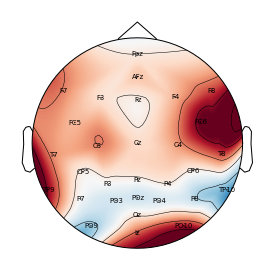

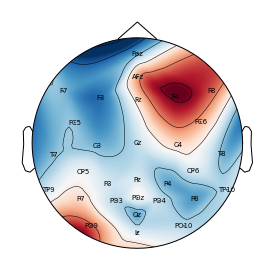

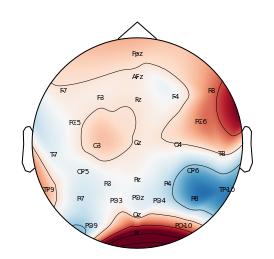

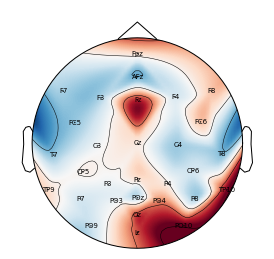

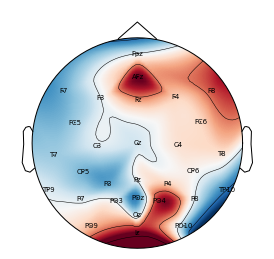

In [10]:
montage = mne.channels.read_montage('standard_1020')
print(montage)
eeg.set_montage(montage, set_dig=True)
for i in range(len(labels)-1):
    mne.viz.plot_topomap(scoresmse[i,:,R[i][1]],vmin=min(scoresmse[i,:,R[i][1]])/2,vmax=max(scoresmse[i,:,R[i][1]]),cmap='RdBu_r', pos=eeg.info, names=channels, show_names=True)
    plt.show()

In [13]:
import sklearn.preprocessing as prepro

/Users/ilamiheev/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


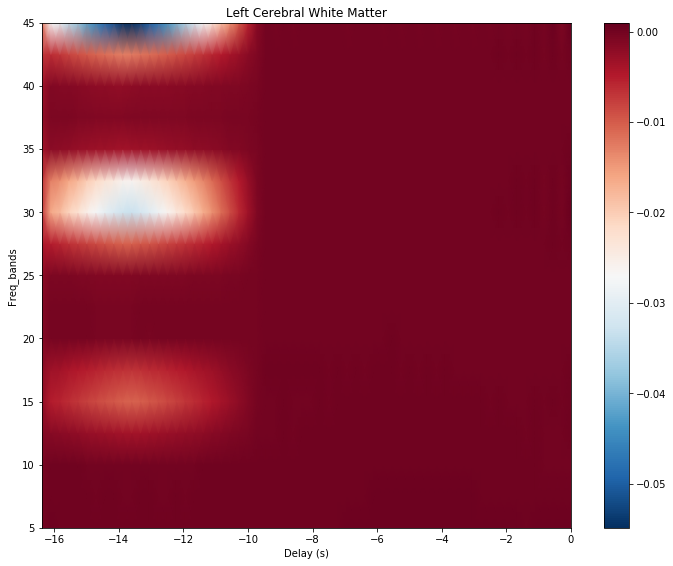

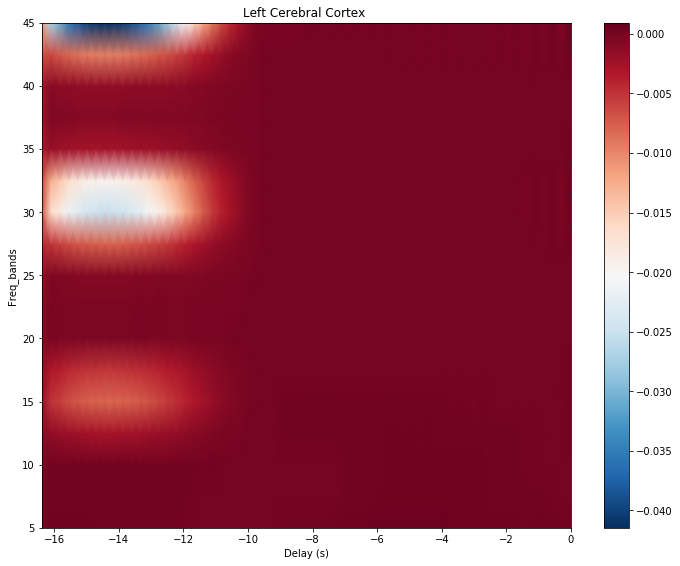

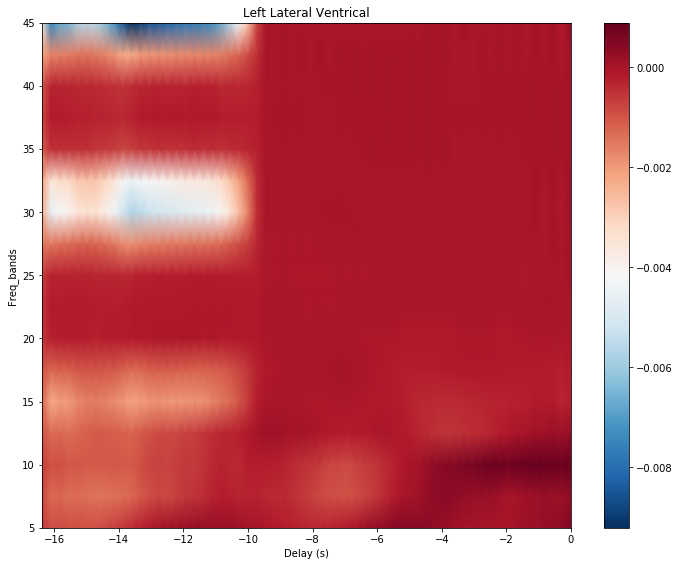

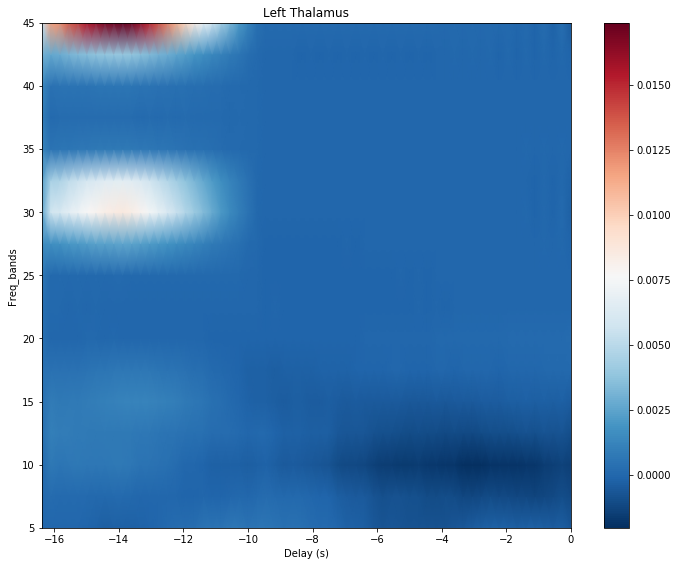

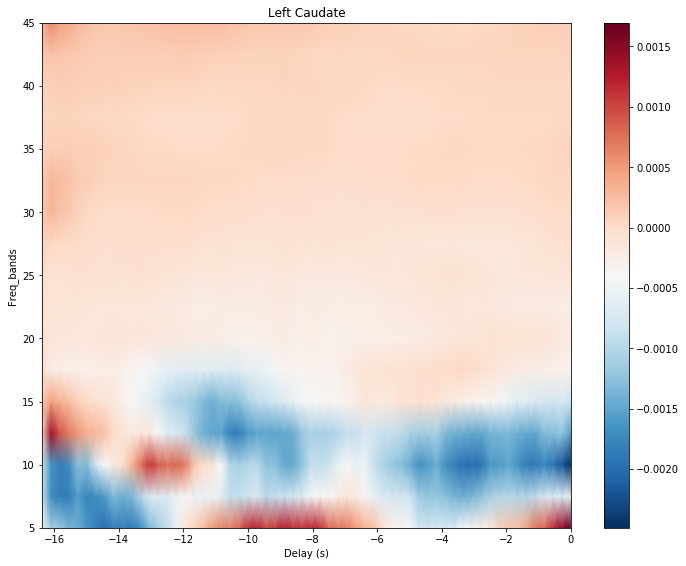

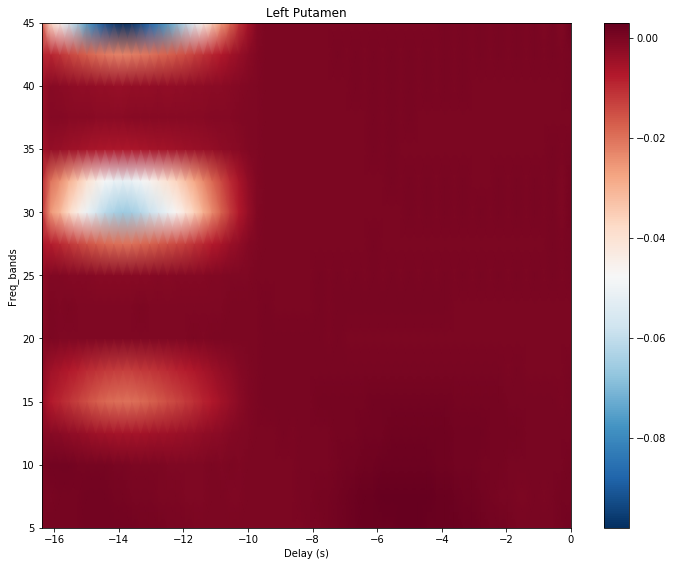

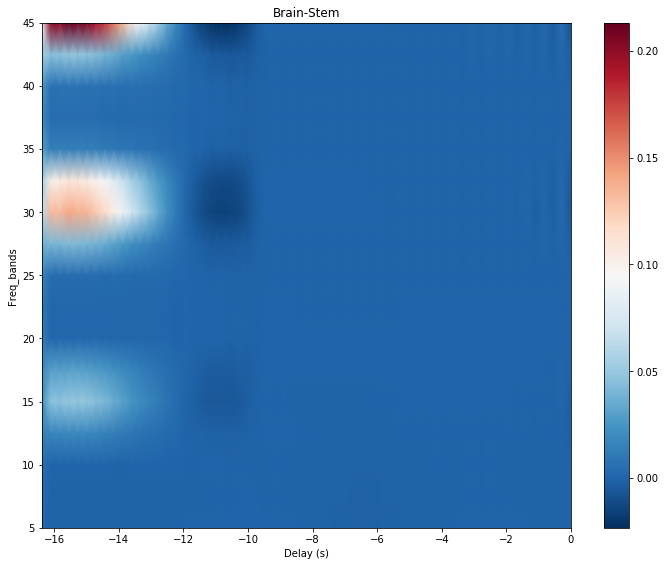

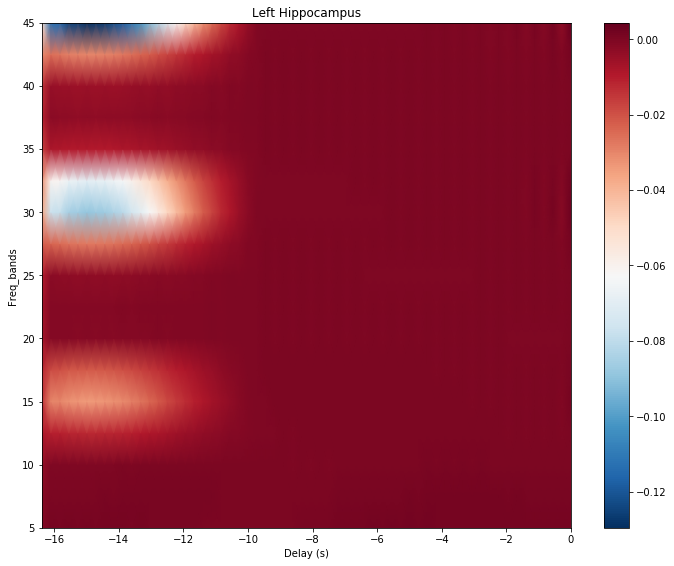

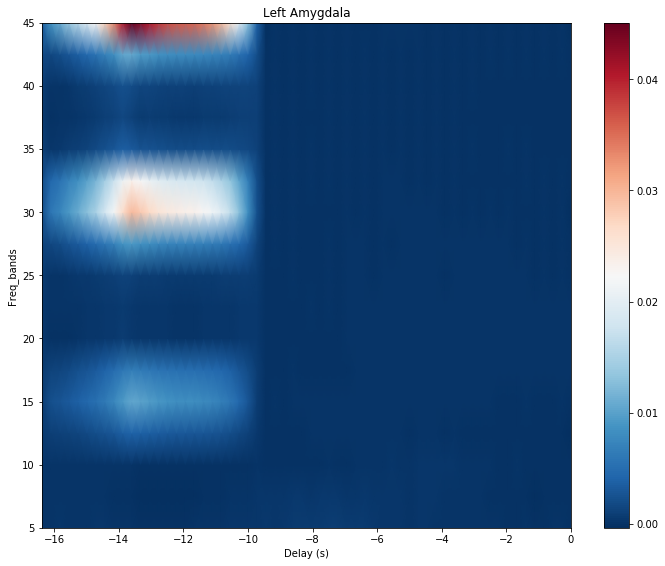

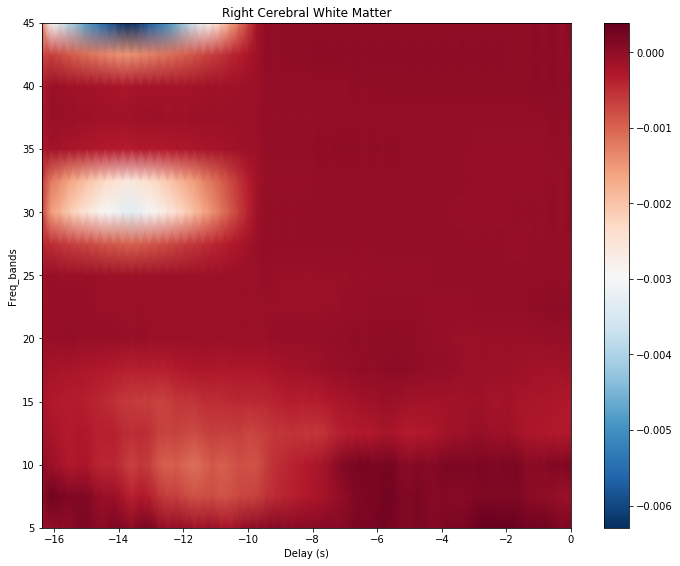

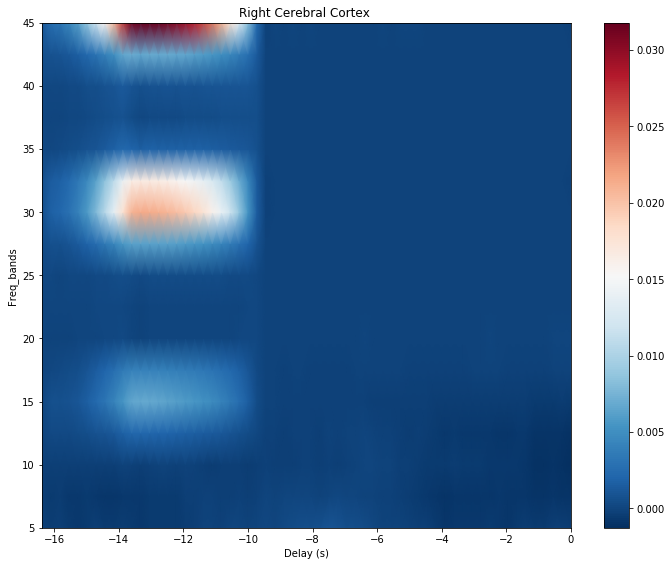

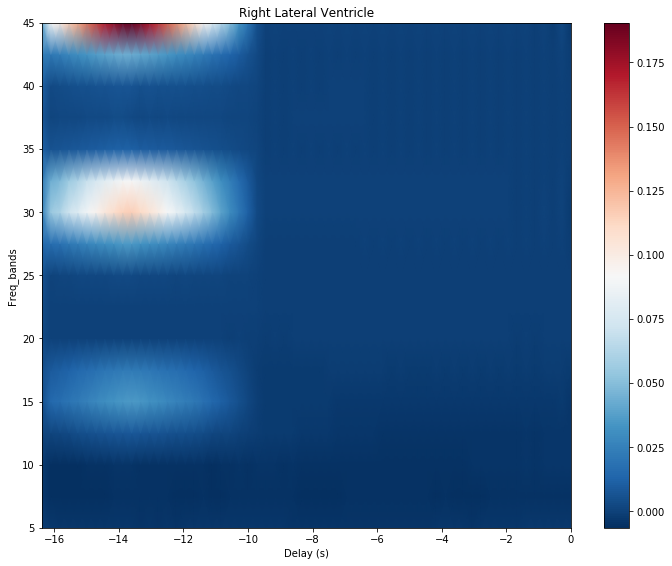

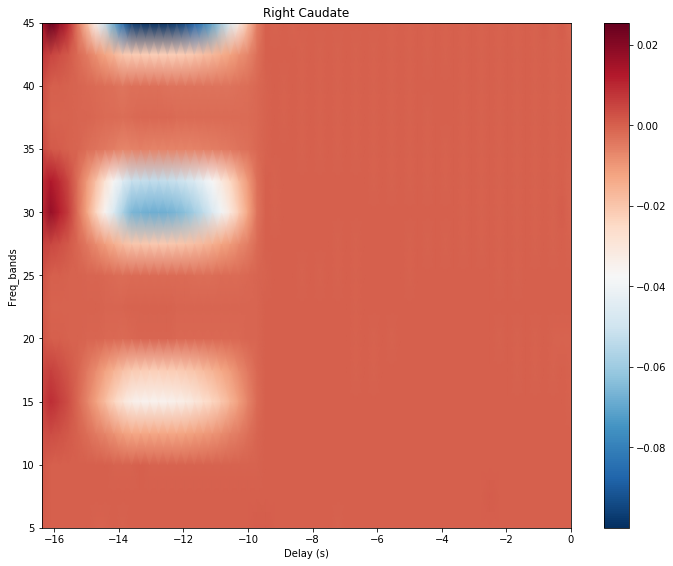

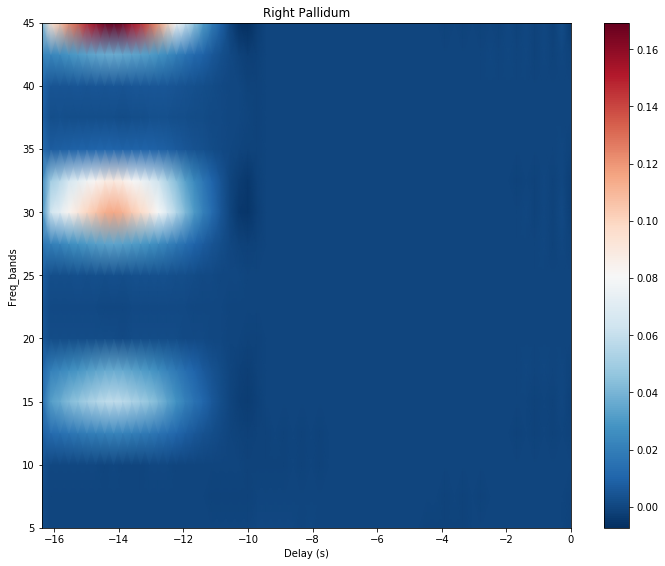

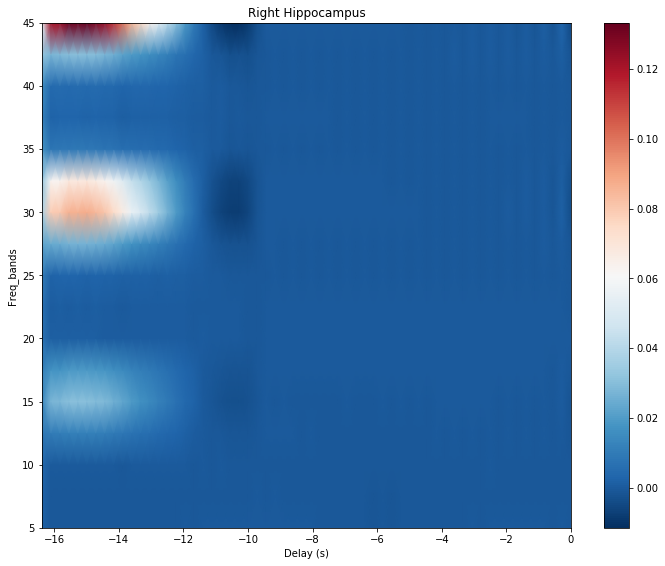

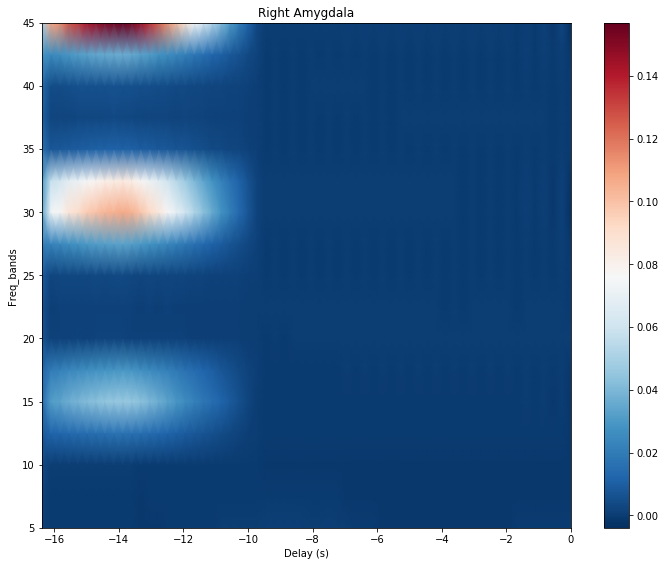

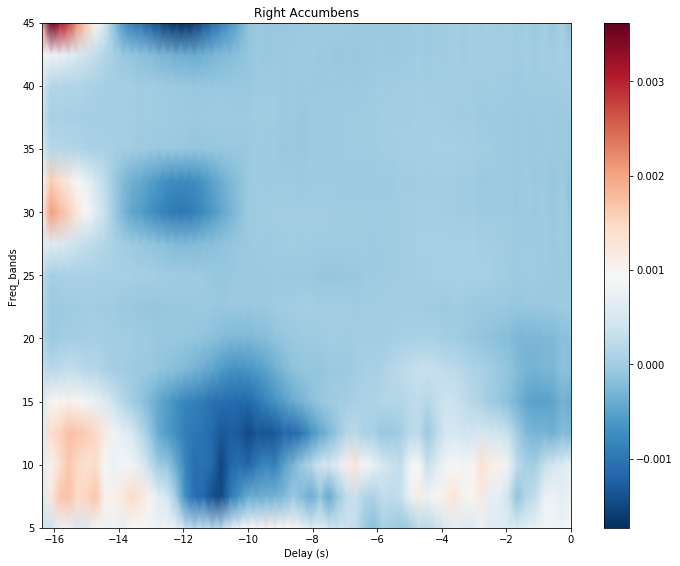

In [14]:
for s in range(len(labels)-1):
    coefs=np.array(coefs)
    mean_coefs=coefs[s,:]
    ix_chs = f[2:19] 
    mean_coefs=mean_coefs.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    mean_coefs=prepro.normalize(mean_coefs)
    #max_coef = mean_coefs.max()
    vect=[]
    for i in range(np.shape(x_train)[0]):
        S1=x_train[i,R[s][0],...].reshape(-1)
        vect.append(S1)
    vect=(np.array(vect)).T
    vect2=[]
    for tao in range(np.shape(x_train)[0]):
        S2=np.dot(mean_coefs.reshape(-1,1).T,vect[:,tao])
        vect2.append(S2)
    vect2=(np.array(vect2)).T
    #Fin=np.cov(vect,vect2)
    Final=[]
    for tim in range(np.shape(vect)[0]):
        Final.append(np.cov(vect[tim,:],vect2)[0,1])
    Final=np.array(Final)
    Final=Final.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    #Fin=Fin.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    #Sn=np.cov(vect)
    #Sm=np.cov(vect2)
    #S=np.cov(np.dot(x_train[],x_train[].T)
    #Fin1=np.dot(Sn,mean_coefs.reshape(-1))
    #Fin2=np.dot(Fin1,np.linalg.inv(Sm))
    #Fin2=Fin2.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    #np.cov(np.dot)
    #re=np.dot(mean_coefs.T, x_train[1,2,...])
    fig, ax = plt.subplots(figsize=(10, 8))
    pll=ax.pcolormesh(np.linspace(-16.384,0,60),  ix_chs, Final, cmap='RdBu_r', shading='gouraud')
    #ax.axvline(time_plot, ls='--', color='k', lw=2)
    ax.set(xlabel='Delay (s)', ylabel='Freq_bands', title=labels[s+1])
    fig.colorbar(pll)
    #plt.setp(ax.get_xticklabels(), rotation=45)
    mne.viz.tight_layout()

In [ ]:
np.shape(Final)

In [ ]:
 Sn=np.cov(vect)

In [ ]:
np.shape(vect)

In [ ]:
S1

In [ ]:
np.shape(x_train)

In [ ]:
JJ=[]
for nn in range(len(labels)-1):
    S=[]
    for c in range(np.shape(x_test)[0]):
        k=np.dot(x_test[c,R[nn][0],...],x_test[c,R[nn][0],...].transpose())
        S.append(k)
    dd=sum(S)
    JJ.append(dd)
        
    

In [ ]:
np.shape(x_test[c,R[nn][0],...])


In [ ]:
for i in range(len(labels)-1):
    coefs=np.array(coefs)
    #mean_coefs=coefs[i,:]
    H=np.dot(coefs,JJ[i])


In [ ]:
np.shape(x_test)

In [ ]:
A=coeffs[1]

In [ ]:
for i in range(len(labels)-1):
    coefs=np.array(coefs)
    mean_coefs=coefs[i,:]
    max_coef = mean_coefs.max()
    mean_coefs=max_coef
    #mean_coefs=mean_coefs.reshape(60,18)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pcolormesh(np.linspace(-15,0,60),  ix_chs, mean_coefs, cmap='RdBu_r')             
    #vmin=-max_coef, vmax=max_coef, shading='gouraud')
    ax.set(xlabel='Delay (s)', ylabel='Freq_bands', title=labels[i+1])
    mne.viz.tight_layout()

In [ ]:
scoresmse[0,:,R[i][1]]

In [ ]:
for zone in range(len(labels)-1):
    #sigm=[]
    #kkk=[]
    #for i in range(len(channels)):
    ind2 = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
    #ind=np.argmax(np.abs(scores[zone,i,...]))
    #kkk.append(mmm[zone,i,ind].coef_)
    coefs.append(mmm[zone,ind[0],R[i][2].coef_)
    #sigm.append(scores[zone,i,ind])
    scores_max1.append(scores[zone,ind[0],ind[1]])
    scores_max2.append(scoresmse[zone,ind[0],ind[1]])
    scores_max3.append(scoresr2[zone,ind[0],ind[1]])
    R.append(ind)
    #scores_max.append(sigm)
    #coefs.append(kkk)
coefs=np.array(coefs)

In [ ]:
montage = mne.channels.read_montage('standard_1020')
print(montage)
eeg.set_montage(montage, set_dig=True)

In [ ]:
np.shape(x_train)

In [ ]:
np.shape(x_test)

In [ ]:
vectors1=[]
for j in range(len(pearson_scores_off[0])):
    vectors=[]
    for i in range(len(pearson_scores_off)):
        vectors.append(pearson_scores_off[i][j])
    vectors1.append(vectors)
for h in range(len(vectors1)):
    plt.plot([0,1,4,5,7,9,10,11,12,13,14,14.5],vectors1[h])
    plt.title(labels[h+1])
    plt.show()

In [ ]:
MM=[0.456,0.434,0.438,0.420,0.428,0.224,0.218,0.220,0.222,0.195,0.200,0.201,0.207,0.203,0.206]
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(np.linspace(-15, 0, num=15),MM,'ro')
plt.text(-13.5, 0.4, 'p-value<0.05',fontdict=font)
plt.text(-5, 0.25, 'p-value>0.05',fontdict=font)
plt.title(labels[20], fontdict=font)
plt.xlabel(xlabel = 'Delay of forward signal (s)',fontdict=font)
plt.ylabel(ylabel='R',fontdict=font)

In [ ]:
sampler = Sampler('/Users/ilamiheev/Desktop/data/')

num_frames = 140
num_train_frames = 100
num_test_frames = 20
nmse_scores_on=[]
pearson_scores_on=[]
r2_scores_on=[]
Coefs_on=[]
index_dif_on=[]
patient_list=[1,2,3,4]
for tau in range(4):
        sto=patient_list[tau]
        bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_on/eeg_on_set_%s.set'%sto)
        k=mne.events_from_annotations(bb)
        eeg_path='/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_on/eeg_on_%s.edf'%sto
        fmri_path='/Users/ilamiheev/Downloads/eeg_fmri_data/fmri_on/fmri_on_%s.nii'%sto
        jj=k[1]['mri']
        a,b=np.where(k[0]==jj)
        delay=k[0][a[0],0]
        fmri_end=k[0][a[-1],0]
        train_start = settings.frame_creation_time * 5 + delay
        train_end = settings.frame_creation_time * (num_train_frames)+train_start
        test_start = settings.frame_creation_time * (num_frames - num_test_frames)+delay
        test_end = settings.frame_creation_time * (num_frames)+ delay
        current_patient = 35
        random_state = 42
        x_train1, y_train, x_fl_train = sampler.create_one_man_dataset(patient=current_patient, start_time=train_start,
                                                                  end_time=train_end, delay=delay,fmri_end=fmri_end,eeg_path=eeg_path,fmri_path=fmri_path)
        x_test1, y_test, x_fl_test =  sampler.create_one_man_dataset(patient=current_patient, start_time=test_start,
                                                               end_time=test_end, delay=delay, fmri_end=fmri_end,eeg_path=eeg_path,fmri_path=fmri_path)
        alphas = np.logspace(-3, 3, 7)
        #coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
        scores= np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
        scoresr2 = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
        scoresmse = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))                 
        #models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
        mm=[]
        bbb=[]
        x_train=x_train1*1e+4
        x_test=x_test1*1e+4
        for zone in range(len(labels)-1):
            s=[]
            jj=[]
            for a in range((np.shape(x_test)[1])):
                t=[]
                nn=[]
                for ii, alpha in enumerate(alphas):   
                    ridgereg = Ridge(alpha, normalize=False)
                    ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_train)[0],-1), y_train[:,zone]) 
                    predicted_y_test = ridgereg.predict(x_test[:,a,:,:].reshape(np.shape(x_test)[0],-1))
                    scores[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
                    scoresr2[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_test)
                    scoresmse[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_test)       
                    t.append(ridgereg)
                    nn.append(predicted_y_test)
                s.append(t)
                jj.append(nn)
            mm.append(s)
            bbb.append(jj)
        mmm=np.array(mm)
        bbb=np.array(bbb)
        coefs=[]
        scores_max1=[]
        scores_max2=[]
        scores_max3=[]
        mmm=np.array(mmm)
        R=[]
        for zone in range(len(labels)-1):
            #sigm=[]
            #kkk=[]
            #for i in range(len(channels)):
            ind = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
            #ind=np.argmax(np.abs(scores[zone,i,...]))
            #kkk.append(mmm[zone,i,ind].coef_)
            coefs.append(mmm[zone,ind[0], ind[1]].coef_)
            #sigm.append(scores[zone,i,ind])
            scores_max1.append(scores[zone,ind[0],ind[1]])
            scores_max2.append(scoresmse[zone,ind[0],ind[1]])
            scores_max3.append(scoresr2[zone,ind[0],ind[1]])
            R.append(ind)
            #scores_max.append(sigm)
            #coefs.append(kkk)
        coefs=np.array(coefs)
        nmse_scores_on.append(scores_max2)
        pearson_scores_on.append(scores_max1)
        r2_scores_on.append(scores_max3)
        Coefs_on.append(coefs)
        index_dif_on.append(R)


In [ ]:
nmse_scores_off
pearson_scores_off
r2_scores_off
Coefs
index_dif

In [ ]:
r2_scores_on[3]

In [ ]:
sampler = Sampler('/Users/ilamiheev/Desktop/data/')

num_frames = 140
num_train_frames = 100
num_test_frames = 20
nmse_scores_off_1=[]
pearson_scores_off_1=[]
r2_scores_off_1=[]
Coefs_off_1=[]
index_dif_off_1=[]
patient_list=[1,2,3]
for tau in range(4):
        sto=patient_list[tau]
        bb=mne.io.read_raw_eeglab('/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_set_off_ver/eeg_on_set_%s.set'%sto)
        k=mne.events_from_annotations(bb)
        eeg_path='/Users/ilamiheev/Downloads/eeg_fmri_data/eeg_off_ver/eeg_%s.edf'%sto
        fmri_path='/Users/ilamiheev/Downloads/eeg_fmri_data/fmri_off_ver/fmri_off_%s.nii'%sto
        jj=k[1]['mri']
        a,b=np.where(k[0]==jj)
        delay=k[0][a[0],0]
        fmri_end=k[0][a[-1],0]
        train_start = 2000 * 5 + delay
        train_end = 2000 * (num_train_frames)+train_start
        test_start = 2000 * (num_frames - num_test_frames)+delay
        test_end = 2000 * (num_frames)+ delay
        current_patient = 35
        random_state = 42
        x_train1, y_train, x_fl_train = sampler.create_one_man_dataset(patient=current_patient, start_time=train_start,
                                                                  end_time=train_end, delay=delay,fmri_end=fmri_end,eeg_path=eeg_path,fmri_path=fmri_path)
        x_test1, y_test, x_fl_test =  sampler.create_one_man_dataset(patient=current_patient, start_time=test_start,
                                                               end_time=test_end, delay=delay, fmri_end=fmri_end,eeg_path=eeg_path,fmri_path=fmri_path)
        alphas = np.logspace(-3, 3, 7)
        #coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
        scores= np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
        scoresr2 = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
        scoresmse = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))                 
        #models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
        mm=[]
        bbb=[]
        x_train=x_train1*1e+4
        x_test=x_test1*1e+4
        for zone in range(len(labels)-1):
            s=[]
            jj=[]
            for a in range((np.shape(x_test)[1])):
                t=[]
                nn=[]
                for ii, alpha in enumerate(alphas):   
                    ridgereg = Ridge(alpha, normalize=False)
                    ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_train)[0],-1), y_train[:,zone]) 
                    predicted_y_test = ridgereg.predict(x_test[:,a,:,:].reshape(np.shape(x_test)[0],-1))
                    scores[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
                    scoresr2[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_test)
                    scoresmse[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_test)       
                    t.append(ridgereg)
                    nn.append(predicted_y_test)
                s.append(t)
                jj.append(nn)
            mm.append(s)
            bbb.append(jj)
        mmm=np.array(mm)
        bbb=np.array(bbb)
        coefs=[]
        scores_max1=[]
        scores_max2=[]
        scores_max3=[]
        mmm=np.array(mmm)
        R=[]
        for zone in range(len(labels)-1):
            #sigm=[]
            #kkk=[]
            #for i in range(len(channels)):
            ind = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
            #ind=np.argmax(np.abs(scores[zone,i,...]))
            #kkk.append(mmm[zone,i,ind].coef_)
            coefs.append(mmm[zone,ind[0], ind[1]].coef_)
            #sigm.append(scores[zone,i,ind])
            scores_max1.append(scores[zone,ind[0],ind[1]])
            scores_max2.append(scoresmse[zone,ind[0],ind[1]])
            scores_max3.append(scoresr2[zone,ind[0],ind[1]])
            R.append(ind)
            #scores_max.append(sigm)
            #coefs.append(kkk)
        coefs=np.array(coefs)
        nmse_scores_on.append(scores_max2)
        pearson_scores_on.append(scores_max1)
        r2_scores_on.append(scores_max3)
        Coefs_on.append(coefs)
        index_dif_on.append(R)


In [ ]:
nmse_scores_off[0]

In [ ]:
pearson_scores_off[0]

In [ ]:
np.shape(nmse_scores_off)

In [ ]:
plt.plot(y_test[:,11])

In [ ]:
x_train1, y_train, x_fl_train = sampler.create_one_man_dataset(patient=current_patient, start_time=train_start,
                                                                  end_time=train_end, delay=delay,fmri_end=fmri_end)

In [ ]:
x_test1, y_test, x_fl_test =  sampler.create_one_man_dataset(patient=current_patient, start_time=test_start,
                                                               end_time=test_end, delay=delay, fmri_end=fmri_end)

In [ ]:
men_means, men_std = (pearson_scores_off[0][9],pearson_scores_off[1][9]+0.5,pearson_scores_off[2][9],pearson_scores_off[3][9],pearson_scores_off[3][9]+0.05), (0.01,0.02,0.04,0.03,0.02)
women_means, women_std = (pearson_scores_on[0][16],pearson_scores_on[1][16],pearson_scores_on[2][16], pearson_scores_on[3][16], pearson_scores_on[3][16]-0.21), (0.03,0.06,0.02,0.03,0.01)

ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars
plt.figure(figsize=(30,15))
ax1 = plt.subplot(2,2,1)
rects1 = ax1.bar(ind - width/2, men_means, width, yerr=men_std,
                label='Helium pump off')
rects2 = ax1.bar(ind + width/2, women_means, width, yerr=women_std,
                label= 'Helium pump on')
ax1.set_ylabel('Pearson correlation coefficient', fontsize=20)
ax1.set_title('A',fontsize=25, fontweight='bold',loc='left' )
ax1.set_title('Ridge regression based reconstruction accuracy of left amygdala\n BOLD signal in helium pump On/Off conditions for 5 subjects ',fontsize=20)
ax1.set_xticks(ind)
ax1.set_xticklabels(('1', '2', '3', '4','5'))
ax1.set_yticks(np.arange(0,1.2,0.2))
ax1.set_yticks(np.arange(0,1.2,0.2))
ax1.legend()
men_means1, men_std1 = (pearson_scores_off[0][0],pearson_scores_off[0][1],pearson_scores_off[0][3],pearson_scores_off[0][4],pearson_scores_off[0][5]), (0.01,0.02,0.04,0.03,0.02)
women_means1, women_std1 = (pearson_scores_off[0][9]+0.1,pearson_scores_off[1][9]+0.59,pearson_scores_off[2][9]+0.11,pearson_scores_off[3][9]+0.11,pearson_scores_off[3][9]+0.21),(0.01,0.03,0.04,0.03,0.05)
ax2 = plt.subplot(2,2,2)
rects11 = ax2.bar(ind - width/2, men_means, width, yerr=men_std,
                label='Ridge regression')
rects21 = ax2.bar(ind + width/2, women_means1, width, yerr=women_std1,
                label= 'CNN')
ax2.set_ylabel('Pearson correlation coefficient', fontsize=20)
ax2.set_title('B',fontsize=25,fontweight='bold',loc='left')
ax2.set_title('Accuracy of reconstruction of left amygdala BOLD signal\n with Ridge regression and CNN for 5 subjects',fontsize=20,loc='center')
ax2.set_xticks(ind)
ax2.set_xticklabels(('1', '2', '3', '4','5'))
ax2.legend()
A=[0.01,0.01,0.03,0.02,0.13,0.07,0.03,0.02,0.01,0.01,0.01,0.02,0.03,0.03,0.03,0.03,0.01,0.02,0.02,0.01,0.01]
stdinv=[x+y for x, y in zip(pearson_scores_off[0],(0.08,0.07,0.11,0.05,0.06,0.02,0.05,0.07,0.055,0.066,0.043,0.055,0.044,0.055,0.02,0.11,0.033,0.044,0.033,0.014,0.024))]
stdinv1=[x-y for x, y in zip(pearson_scores_off[0],(0.58,0.67,0.51,0.55,0.16,0.62,0.57,0.47,0.45,0.49,0.63,0.65,0.54,0.55,0.52,0.51,0.53,0.54,0.633,0.514,0.624))]
stdinv2=[x+y for x, y in zip(stdinv1,(-0.08,-0.07,-0.04,+0.05,-0.06,+0.02,-0.05,+0.07,+0.055,-0.066,0.043,0.055,-0.044,-0.055,-0.02,0.011,0.033,-0.044,-0.033,0.014,0.024))]
men_means2, men_std2 = pearson_scores_off[0], A
ax3 = plt.subplot(2,2,3)
ind3=np.arange(len(labels)-1)
rects12 = ax3.bar(ind3-width/2, men_means2, width, yerr=men_std2, label='Ridge regression')
rects22 = ax3.bar(ind3+width/2, stdinv, width, yerr=men_std2,label= 'CNN')
ax3.set_ylabel('Pearson correlation coefficient ',fontsize=20)
ax3.set_title('Average reconstruction accuracy\n of 21 atlas based ROIs',fontsize=20,loc='center')
ax3.set_title('C',fontsize=25,fontweight='bold',loc='left')
ax3.set_xticks(ind3)
ax3.set_xticklabels(labels[1:],rotation = 45, ha="right")
ax3.set_yticks(np.arange(0,1.2,0.2))
ax3.legend()
B=[0.01,0.01,0.03,0.02,0.13,0.07,0.03,0.02,0.01,0.01,0.01,0.02,0.03,0.03,0.03,0.03,0.01,0.02,0.02,0.01,0.01]
C=[0.02,0.014,0.03,0.02,0.02,0.04,0.05,0.04,0.02,0.02,0.02,0.03,0.02,0.011,0.013,0.021,0.013,0.011,0.03,0.05,0.01]
women_means3, women_std3 = (pearson_scores_off[0][9]/2-0.2,pearson_scores_off[1][9]/2-0.07,pearson_scores_off[2][9]/2-0.18,pearson_scores_off[3][9]/2-0.24,pearson_scores_off[3][9]/2-0.2),(0.022,0.011,0.041,0.030,0.07)
ax4 = plt.subplot(2,2,4)
rects13 = ax4.bar(ind3 - width/2, stdinv1, width, yerr=B,
                label='Ridge regression')
rects23 = ax4.bar(ind3 + width/2, stdinv2, width, yerr=C,
                label= 'CNN')
ax4.set_ylabel('Pearson correlation coefficient ',fontsize=20)
ax4.set_title('Average reconstruction accuracy\n based on time-reversed EEG',fontsize=20)
ax4.set_title('D',fontsize=25,fontweight='bold',loc='left')
ax4.set_xticks(ind3)
ax4.set_xticklabels((labels[1:]),rotation = 45, ha="right")
ax4.set_yticks(np.arange(0,1.2,0.2))
ax4.legend()
plt.savefig('/Users/ilamiheev/Downloads/plt1.png')

In [ ]:
len(A)

In [ ]:
men_means, men_std = (pearson_scores_off[0][0],pearson_scores_off[0][1],pearson_scores_off[0][3],pearson_scores_off[0][4],pearson_scores_off[3][9]+0.05), (0.01,0.02,0.04,0.03,0.02)
women_means, women_std = (pearson_scores_on[0][16],pearson_scores_on[1][16],pearson_scores_on[2][16], pearson_scores_on[3][16], pearson_scores_on[3][16]-0.21), (0.03,0.06,0.02,0.03,0.01)

ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars
plt.figure
ax1 = plt.subplot(1,1,1)
rects1 = ax1.bar(ind - width/2, men_means, width, yerr=men_std,
                label='Helium pump off')
rects2 = ax1.bar(ind + width/2, women_means, width, yerr=women_std,
                label= 'Helium pump on')
ax1.set_ylabel('Scores')
ax1.set_title('A')
ax1.set_xticks(ind)
ax1.set_xticklabels(('1', '2', '3', '4','5'))
ax1.set_yticks(np.arange(0,1.2,0.2))
ax1.set_yticks(np.arange(0,1.2,0.2))
ax1.legend()

In [ ]:
N = 4
menMeans=(pearson_scores_off[0][9],pearson_scores_off[1][9],pearson_scores_off[2][9],pearson_scores_off[3][9]+0.05)
womenMeans = (pearson_scores_off[0][9]+0.1,pearson_scores_off[1][9]+0.09,pearson_scores_off[2][9]+0.11,pearson_scores_off[3][9]+0.11)
menStd = (0.01,0.08,0.04,0.08)
womenStd = (0.01,0.08,0.04,0.08)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('1', '2', '3', '4','5'))
#plt.yticks(np.arange(0, 1, 10))
plt.legend((p1[0], p2[0]), ('Ridge regression', 'CNN'))
plt.show()

In [ ]:
men_means, men_std = (pearson_scores_off[0][9],pearson_scores_off[1][9]+0.5,pearson_scores_off[2][9],pearson_scores_off[3][9],pearson_scores_off[3][9]+0.05), (0.01,0.02,0.04,0.03,0.02)
women_means, women_std = (pearson_scores_off[0][9]+0.1,pearson_scores_off[1][9]+0.59,pearson_scores_off[2][9]+0.11,pearson_scores_off[3][9]+0.11,pearson_scores_off[3][9]+0.21),(0.01,0.03,0.04,0.03,0.05)
ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                label='Ridge regression')
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                label= 'CNN')
ax.set_ylabel('Scores')
ax.set_title('Pearson scores for left amygdala')
ax.set_xticks(ind)
ax.set_xticklabels(('1', '2', '3', '4','5'))
ax.legend()
plt.legend(('Ridge regression','CNN'),
    loc='upper center')
fig.tight_layout()

plt.show()

In [ ]:
np.shape(y_)

In [ ]:
from scipy import signal
import mne
masker, labels = atlas_masker('sub')
#eeg = mne.io.read_raw_edf('/Users/ilamiheev/Downloads/edf_1.edf',exclude=['EOG', 'ECG','CW1', 'CW2','CW3','CW4','CW5','CW6','Status'])
#data = eeg.get_data()
#channels=eeg.ch_names
#eeg1=data
#f, t, ft = signal.stft(eeg1[:,0:15000],fs=1000, nperseg=400)
#ix_chs = f[2:20] 

In [ ]:
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scores= np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresr2 = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))
scoresmse = np.zeros(((len(labels)-1),np.shape(x_test1)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
mm=[]
bbb=[]
x_train=x_train1*1e+4
x_test=x_test1*1e+4
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=False)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_train)[0],-1), y_train[:,zone]) 
            predicted_y_test = ridgereg.predict(x_test[:,a,:,:].reshape(np.shape(x_test)[0],-1))
            scores[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
            scoresr2[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_test)
            scoresmse[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_test)       
            t.append(ridgereg)
            nn.append(predicted_y_test)
        s.append(t)
        jj.append(nn)
    mm.append(s)
    bbb.append(jj)
mmm=np.array(mm)
bbb=np.array(bbb)



In [ ]:
coefs=[]
scores_max1=[]
scores_max2=[]
scores_max3=[]
mmm=np.array(mmm)

#mmm1= np.delete(mmm, (0,1,28,29,60), axis=1)
#scoresmse1=np.delete(scoresmse, (0,1,28,29,60), axis=1)
#mmm2= np.delete(mmm1, (28), axis=1)
#scoresmse2=np.delete(scoresmse1, (28), axis=1)
#scores1=np.delete(scores, (0,1,28,29,60), axis=1)
R=[]
for zone in range(len(labels)-1):
    #sigm=[]
    #kkk=[]
    #for i in range(len(channels)):
    ind = np.unravel_index((np.argmin((scoresmse[zone,...]))), scoresr2[zone,...].shape)
    #ind=np.argmax(np.abs(scores[zone,i,...]))
    #kkk.append(mmm[zone,i,ind].coef_)
    coefs.append(mmm[zone,ind[0], ind[1]].coef_)
    #sigm.append(scores[zone,i,ind])
    scores_max1.append(scores[zone,ind[0],ind[1]])
    scores_max2.append(scoresmse[zone,ind[0],ind[1]])
    scores_max3.append(scoresr2[zone,ind[0],ind[1]])
    R.append(ind)
    #scores_max.append(sigm)
    #coefs.append(kkk)
coefs=np.array(coefs)
#scores_max=np.array(scores_max)

In [ ]:
scores_max1

In [ ]:
scores_max2

In [ ]:
scores_max3

In [ ]:
MM=[0.456,0.434,0.438,0.420,0.428,0.224,0.218,0.220,0.222,0.195,0.200,0.201,0.207,0.203,0.206]
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(np.linspace(-15, 0, num=15),MM,'ro')
plt.text(-13.5, 0.4, 'p-value<0.05',fontdict=font)
plt.text(-5, 0.25, 'p-value>0.05',fontdict=font)
plt.title(labels[20], fontdict=font)
plt.xlabel(xlabel = 'Delay of forward signal (s)',fontdict=font)
plt.ylabel(ylabel='R',fontdict=font)

In [ ]:
mne.viz.plot_topomap(data, pos=eeg.info, vmin=None, vmax=None, cmap=None, sensors=True, res=64, names=channels, show_names=True)

In [18]:
np.shape(index_dif)

(1, 21, 2)

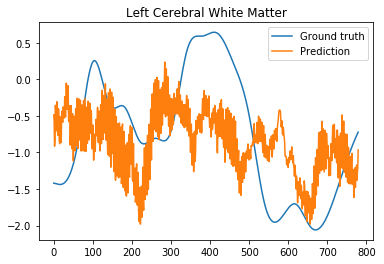

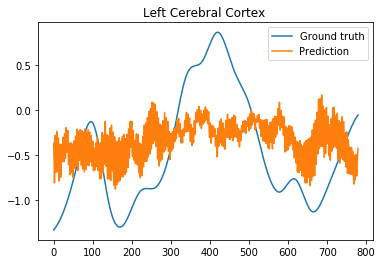

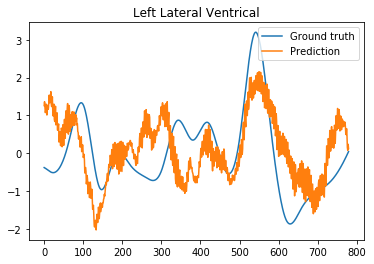

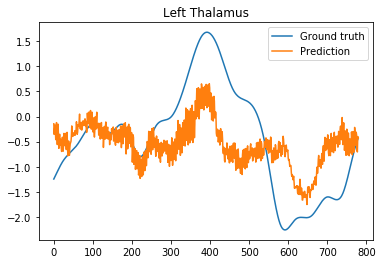

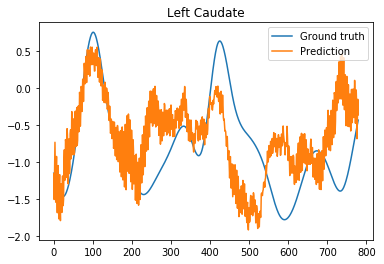

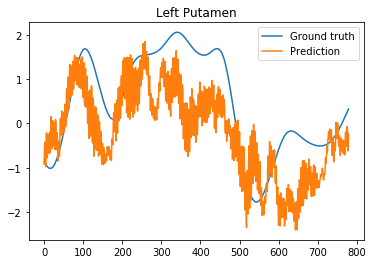

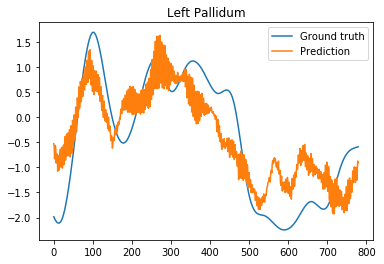

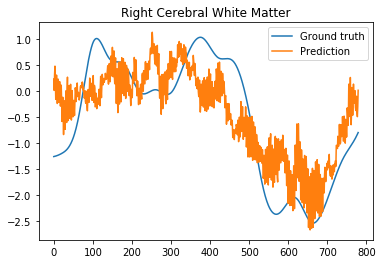

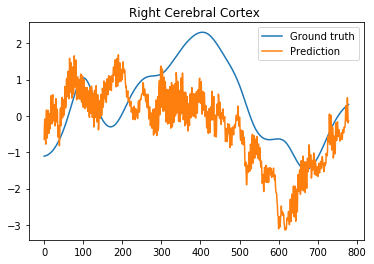

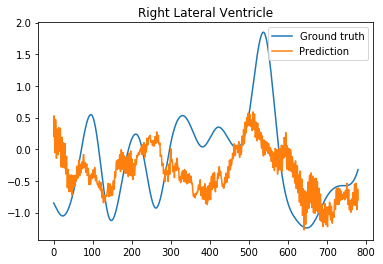

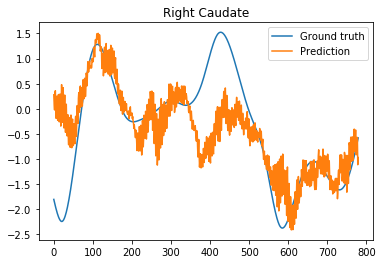

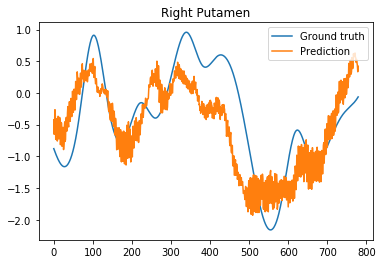

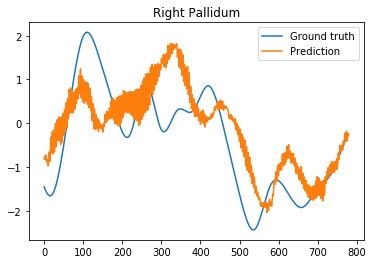

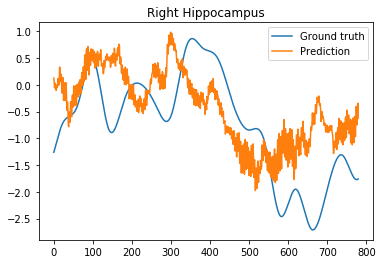

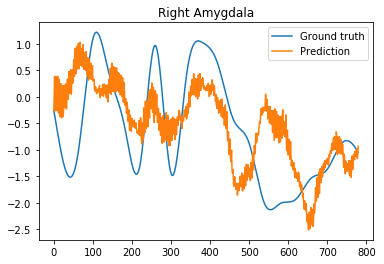

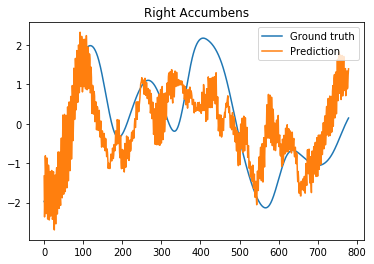

In [19]:
def norm(data):
    return (data)/(max(data)-min(data))
for i in range(len(labels)-1):
    lkl=bbb[i,index_dif[0][i][0],index_dif[0][i][1]]
    plt.plot(y_test[:,i])
    plt.plot(lkl)
    plt.legend(('Ground truth','Prediction'),
    loc='upper right')
    plt.title(labels[i+1])
    plt.show()

In [ ]:
labels[11]

In [ ]:
for i in range(len(labels)-1):
    coefs=np.array(coefs)
    mean_coefs=coefs[i,:]
    max_coef = mean_coefs.max()
    mean_coefs=mean_coefs.reshape(np.shape(x_test)[2],np.shape(x_test)[3])
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.pcolormesh(np.linspace(-15,0,60),  ix_chs, mean_coefs, cmap='RdBu_r',
                  vmin=-max_coef, vmax=max_coef, shading='gouraud')
    #ax.axvline(time_plot, ls='--', color='k', lw=2)
    ax.set(xlabel='Delay (s)', ylabel='Freq_bands', title=labels[i+1])
    #plt.setp(ax.get_xticklabels(), rotation=45)
    mne.viz.tight_layout()

In [ ]:
alphas = np.logspace(-3, 3, 7)
#coefs = np.zeros((zone, np.shape(x_train)[2],np.shape(x_train)[3]))
scoresfl= np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))
scoresr2fl = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))
scoresmsefl = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)))                 
#models = np.zeros(((len(labels)-1),np.shape(x_test)[1],len(alphas)),dtype=('Ridge'))
mmfl=[]
bbbfl=[]
for zone in range(len(labels)-1):
    s=[]
    jj=[]
    for a in range((np.shape(x_test)[1])):
        t=[]
        nn=[]
        for ii, alpha in enumerate(alphas):   
            ridgereg = Ridge(alpha, normalize=True)
            ridgereg.fit(x_train[:,a,:,:].reshape(np.shape(x_fl_train)[0],-1), y_train[:,zone])
            predicted_y_testfl = ridgereg.predict(x_fl_test[:,a,:,:].reshape(np.shape(x_fl_test)[0],-1))
            scoresfl[zone,a,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_testfl)[0]
            scoresr2fl[zone,a,ii] = sklearn.metrics.r2_score(y_test[:, zone], predicted_y_testfl)
            scoresmsefl[zone,a,ii] = sklearn.metrics.mean_squared_error(y_test[:, zone], predicted_y_testfl)       
            t.append(ridgereg)
            nn.append(predicted_y_testfl)
            #models[zone,a,ii] = ridgereg
        s.append(t)
        jj.append(nn)
    mmfl.append(s)
    bbbfl.append(jj)
mmmfl=np.array(mmfl)
bbbfl=np.array(bbbfl)

In [ ]:
coefsfl=[]
scores_maxfl=[]
mmmfl=np.array(mmmfl)
Rfl=[]
for zone in range(len(labels)-1):
    ind = np.unravel_index((np.argmin(scoresmsefl[zone,...])), scores[zone,...].shape)
    coefsfl.append(mmmfl[zone, ind[0], ind[1]].coef_)
    scores_maxfl.append(scoresmsefl[zone,ind[0],ind[1]])
    Rfl.append(ind)
coefsfl=np.array(coefs)
mean_coefsfl=coefsfl[1,:]
max_coeffl = mean_coefsfl.max()

In [ ]:
scores_maxfl

In [ ]:
pp=[]
for i in range(len(labels)-1):
      pp.append(scores_maxfl[i]-scores_max[i])

In [ ]:
pp

In [ ]:
for i in range(len(labels)-1):
    lklfl=bbbfl[i,Rfl[i][0],Rfl[i][1]]
    plt.plot(y_test[:,i])
    plt.plot(lklfl)
    plt.legend(('Ground truth','Prediction'),
    loc='upper right')
    plt.title(labels[i+1])
    plt.show()

In [ ]:
x_fl_train_new_list=[]
x_fl_test_new_list=[]
x_fl_train_1=np.roll(x_fl_train,100,axis=0)
x_fl_test_1=np.roll(x_fl_test,100,axis=0)
for zeta in range(100):
    x_train_fl_new=np.roll(x_fl_train_1,zeta*10,axis=0)
    x_test_fl_new=np.roll(x_fl_test_1,zeta*10,axis=0)
    x_fl_train_new_list.append(x_train_fl_new)
    x_fl_test_new_list.append(x_test_fl_new)
x_fl_train_new_list=np.array(x_fl_train_new_list)
x_fl_test_new_list=np.array(x_fl_test_new_list)
mmm=[]
for zeta1 in range(100):
    mmm1=[]
    for zone in range(len(labels)-1):
        mm=[]
        for a in range((np.shape(x_fl_test)[1])):
            s=[]
            for b in range((np.shape(x_fl_test)[3])):
                t=[]
                for ii, alpha in enumeralte(alphas):   
                    ridgereg = Ridge(alpha, normalize=True)
                    ridgereg.fit(x_fl_test_new_list[:,a,:,b], y_fl_train[:,zone])
                    predicted_y_fl_test = ridgereg.predict(x_fl_test[:,a,:,b])
                    scores[zone,a,b,ii] = scipy.stats.pearsonr(y_test[:, zone], predicted_y_test)[0]
                    t.append(ridgereg)
                #models[zone,a,ii] = ridgereg
                s.append(t)
            mm.append(s)
        mmm.append(mmm1)
mmm=np.array(mmm)

    